# Configure the Library

In [1]:
import numpy as np
import pandas as pd
import os
import random
import time

import re
import string
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")
plt.style.use('dark_background')

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.utils.data import dataloader, dataset

import transformers
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn.metrics import f1_score, mean_squared_error, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold 

import warnings
warnings.simplefilter('ignore')

c:\Users\mikew\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# load dataset

In [2]:
train = pd.read_csv('./dataset/train.csv.zip', nrows=200)
test = pd.read_csv('./dataset/test.csv.zip', nrows=200)
test_label = pd.read_csv('./dataset/test_labels.csv.zip', nrows=200)
train.head()
#test.head()
#test_label.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Clean the dataset -- helper function for removing non-sense fragment

In [3]:
def clean_text(text):

    text = re.sub('\[.*?\]', '', text)
    #pattern = [zero or more character]

    text = re.sub('https?://\S+|www\.\S+', '', text)
    #pattern = removes (http),://, 'and' www.
    
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    #pattern = any punctionation

    text = re.sub('\n', '', text)
    #pattern = any new line

    text = re.sub('\w*\d\w*', '', text)
    #pattern = any from[a-zA-Z0-9_], any from[0-9], any from [a-zA-Z0-9_]

    return text


train['clean'] = train['comment_text'].apply(str).apply(lambda x: clean_text(x))
test['clean'] = test['comment_text'].apply(str).apply(lambda x: clean_text(x))

# DataLoader

In [4]:
class BertDataSet(dataset.Dataset):
    
    def __init__(self, texts, labels, tokenizer, max_len, if_train=True):
        self.texts = texts
        #self.labels = labels.to_numpy()
        self.if_train = if_train
        if self.if_train:
            self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        text = str(self.texts.iloc[item])
        
        if self.if_train:
            label = self.labels.iloc[item]

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=False,
            return_attention_mask=True,
            truncation=True
        )

        if self.if_train:
            return {
                #'text': text,
                'input_ids':torch.tensor(inputs['input_ids'], dtype=torch.long),
                'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
                'labels': torch.tensor(label, dtype=torch.float)
            }
        else:
            return{
            'input_ids':torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long)
            }
     

# Test

In [5]:
#senten_len = []
#for sentence in tqdm(train['clean']):
#    token_words = tokenizer.encode_plus(sentence, padding=True, max_length = 768)['input_ids'] # Token indices sequence length is longer than the specified maximum sequence length for this model (569 > 512). Running this sequence through the model will result in indexing errors
#    senten_len.append(len(token_words))


In [6]:
token = next(iter(train['clean']))
print(type(train['clean']))

<class 'pandas.core.series.Series'>


# Model definition

In [7]:
train_batch = 32
valid_batch = 32

epochs = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(f"The devices using is : {device}")

#Using K-folder
kf = KFold(n_splits=5, shuffle=True, random_state=42)
# fold_index = 0

fold_losses = []
fold_valid = []

best_model  = None
best_loss = None
best_index = 0

loss_fn = nn.BCEWithLogitsLoss() # for sigmoid on multi-label tasks
loss_fn.to(device)

tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')
model = transformers.BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels = 6)
model.to(device)

The devices using is : cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

# train

In [8]:
for train_index, valid_index in kf.split(train):
    train_kf = train.iloc[train_index]
    valid_kf = train.iloc[valid_index]
    
    train_dataset = BertDataSet(train_kf['clean'], train_kf[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']], tokenizer, 77)
    valid_dataset = BertDataSet(valid_kf['clean'], valid_kf[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']], tokenizer, 77)
    
    #train_dataset = BertDataSet(train_kf, tokenizer, eval_mode = False)
    #valid_dataset = BertDataSet(valid_kf, tokenizer, eval_mode = True)
    
    train_dataloader = dataloader.DataLoader(train_dataset, batch_size = train_batch, pin_memory = True, num_workers = 0, shuffle = True)
    valid_dataloader = dataloader.DataLoader(valid_dataset, batch_size = valid_batch, pin_memory = True, num_workers = 0, shuffle = False)
    
    optimizer = AdamW(model.parameters(), lr=1e-5)

    training_losses = []
    valid_losses = []
    
    
    for epoch in range(epochs):   
        
        optimizer.zero_grad()
        model.train()
        total_loss = 0
        valid_loss = 0
        with torch.cuda.amp.autocast():
     
            for batch in tqdm(train_dataloader):
                
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['mask'].to(device)
                labels = batch['labels'].to(device)
                
                outputs = model(input_ids, attention_mask=attention_mask, labels = labels)
                outputs = outputs['logits']
                
                toxic_labels = batch['labels'].to(device, non_blocking=True)
                loss = loss_fn(outputs, toxic_labels)
                total_loss += loss.item()
                
                loss.backward()
                optimizer.step()
                
            avg_loss = total_loss / len(train_dataloader)
            training_losses.append(avg_loss)
            print(f"Training Epoch {epoch+1}/{epochs}, Loss: {avg_loss}. {len(training_losses)}")
        
            model.eval()
            true_labels = []
            predictions = []
            
            for batch in valid_dataloader:
                
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['mask'].to(device)
                labels = batch['labels'].to(device)
                        
                
                with torch.no_grad():
                    outputs = model(input_ids, attention_mask = attention_mask)
                    
                outputs = outputs['logits'].squeeze(-1)
                
                toxic_labels = batch['labels'].to(device, non_blocking=True)
                loss = loss_fn(outputs, toxic_labels)
                valid_loss += loss.item()
                
            avg_valid_loss = valid_loss / len(valid_dataloader)
            valid_losses.append(avg_valid_loss)   
            #f1 = f1_score(true_labels, predictions, average='weighted')  #Error : Classification metrics can't handle a mix of multilabel-indicator and binary targets       
            print(f"Validating Epoch {epoch+1}/{epochs}, Loss: {avg_valid_loss}")
        
        if( best_loss == None or avg_valid_loss > best_loss ):
            
            best_model = model
            best_loss = avg_valid_loss
            fold_losses = training_losses
            fold_valid = valid_losses
            print("Find the better model")

    
best_model.save_pretrained('./fintune_bert')    
    

100%|██████████| 5/5 [00:00<00:00,  5.48it/s]


Training Epoch 1/5, Loss: 0.6449377298355102. 1
Validating Epoch 1/5, Loss: 0.6395702064037323
Find the better model


100%|██████████| 5/5 [00:00<00:00,  7.46it/s]


Training Epoch 2/5, Loss: 0.5887743949890136. 2
Validating Epoch 2/5, Loss: 0.5828498899936676


100%|██████████| 5/5 [00:00<00:00,  7.62it/s]


Training Epoch 3/5, Loss: 0.53016676902771. 3
Validating Epoch 3/5, Loss: 0.5289711952209473


100%|██████████| 5/5 [00:00<00:00,  6.97it/s]


Training Epoch 4/5, Loss: 0.4753921389579773. 4
Validating Epoch 4/5, Loss: 0.47278955578804016


100%|██████████| 5/5 [00:00<00:00,  7.27it/s]


Training Epoch 5/5, Loss: 0.42331679463386535. 5
Validating Epoch 5/5, Loss: 0.42111624777317047


100%|██████████| 5/5 [00:00<00:00,  7.12it/s]


Training Epoch 1/5, Loss: 0.3901070296764374. 1
Validating Epoch 1/5, Loss: 0.37164193391799927


100%|██████████| 5/5 [00:00<00:00,  7.28it/s]


Training Epoch 2/5, Loss: 0.42584585547447207. 2
Validating Epoch 2/5, Loss: 0.41206982731819153


100%|██████████| 5/5 [00:00<00:00,  7.35it/s]


Training Epoch 3/5, Loss: 0.39165161848068236. 3
Validating Epoch 3/5, Loss: 0.3737604022026062


100%|██████████| 5/5 [00:00<00:00,  7.33it/s]


Training Epoch 4/5, Loss: 0.3094938337802887. 4
Validating Epoch 4/5, Loss: 0.2920687198638916


100%|██████████| 5/5 [00:00<00:00,  7.33it/s]


Training Epoch 5/5, Loss: 0.324062842130661. 5
Validating Epoch 5/5, Loss: 0.3022223711013794


100%|██████████| 5/5 [00:00<00:00,  7.53it/s]


Training Epoch 1/5, Loss: 0.3191315829753876. 1
Validating Epoch 1/5, Loss: 0.2767959088087082


100%|██████████| 5/5 [00:00<00:00,  7.69it/s]


Training Epoch 2/5, Loss: 0.2839849442243576. 2
Validating Epoch 2/5, Loss: 0.23632366955280304


100%|██████████| 5/5 [00:00<00:00,  7.64it/s]


Training Epoch 3/5, Loss: 0.29448906183242796. 3
Validating Epoch 3/5, Loss: 0.25012771785259247


100%|██████████| 5/5 [00:00<00:00,  7.75it/s]


Training Epoch 4/5, Loss: 0.27081149220466616. 4
Validating Epoch 4/5, Loss: 0.2231428176164627


100%|██████████| 5/5 [00:00<00:00,  7.61it/s]


Training Epoch 5/5, Loss: 0.2422200232744217. 5
Validating Epoch 5/5, Loss: 0.18854229897260666


100%|██████████| 5/5 [00:00<00:00,  7.49it/s]


Training Epoch 1/5, Loss: 0.2108321577310562. 1
Validating Epoch 1/5, Loss: 0.3698199987411499


100%|██████████| 5/5 [00:00<00:00,  7.61it/s]


Training Epoch 2/5, Loss: 0.21823955178260804. 2
Validating Epoch 2/5, Loss: 0.3770175576210022


100%|██████████| 5/5 [00:00<00:00,  7.56it/s]


Training Epoch 3/5, Loss: 0.19847580790519714. 3
Validating Epoch 3/5, Loss: 0.3695429489016533


100%|██████████| 5/5 [00:00<00:00,  7.39it/s]


Training Epoch 4/5, Loss: 0.18755644857883452. 4
Validating Epoch 4/5, Loss: 0.3684580475091934


100%|██████████| 5/5 [00:00<00:00,  7.28it/s]


Training Epoch 5/5, Loss: 0.18609507083892823. 5
Validating Epoch 5/5, Loss: 0.37560708820819855


100%|██████████| 5/5 [00:00<00:00,  7.52it/s]


Training Epoch 1/5, Loss: 0.1968727618455887. 1
Validating Epoch 1/5, Loss: 0.13724078238010406


100%|██████████| 5/5 [00:00<00:00,  7.48it/s]


Training Epoch 2/5, Loss: 0.1954207181930542. 2
Validating Epoch 2/5, Loss: 0.1397283598780632


100%|██████████| 5/5 [00:00<00:00,  7.69it/s]


Training Epoch 3/5, Loss: 0.19192878603935243. 3
Validating Epoch 3/5, Loss: 0.13517405837774277


100%|██████████| 5/5 [00:00<00:00,  7.58it/s]


Training Epoch 4/5, Loss: 0.17640503644943237. 4
Validating Epoch 4/5, Loss: 0.122822105884552


100%|██████████| 5/5 [00:00<00:00,  7.65it/s]


Training Epoch 5/5, Loss: 0.17110242545604706. 5
Validating Epoch 5/5, Loss: 0.12105303257703781


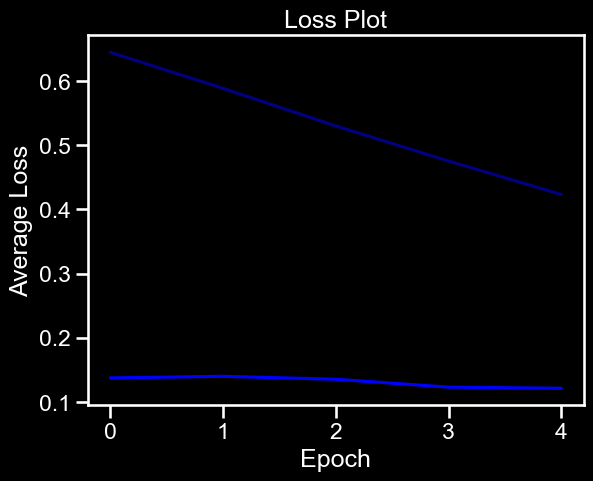

In [9]:
# draw the losses of the best model
best_train_losses = fold_losses
best_valid_losses = valid_losses

plt.plot(best_train_losses, color='navy')
plt.plot(best_valid_losses, color = 'blue')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Loss Plot')
plt.show()


In [10]:
print(len(best_train_losses))

5


# Evaluation

In [38]:
tokenizer = None
best_model = None
model = None
torch.cuda.empty_cache()

In [48]:
def get_roc_auc(test_label, y_prob):
    # input: test_labels dim: (num_samples, num_labels), y_prob dim: (num_samples, num_labels)
    y_label_np = test_label.numpy() if hasattr(test_label, 'numpy') else test_label.cpu().numpy()
    y_test_np = y_prob.numpy() if hasattr(y_prob, 'numpy') else y_prob.cpu().numpy()

    n_classes = y_label_np.shape[1]  # Number of classes/labels

# Initialize lists to store fpr and tpr for each label
    all_fpr = []
    all_tpr = []
    label_names = []
    auc_scores = []
    # Compute ROC curve for each label
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_label_np[:, i], y_test_np[:, i])
        all_fpr.append(fpr)
        all_tpr.append(tpr)
        auc = roc_auc_score(y_label_np[:, i], y_test_np[:, i])
        label_names.append(f"Label {i}")
        auc_scores.append(auc)

    # Plot ROC curve for each label
    plt.figure(figsize=(10, 6))
    for i in range(n_classes):
        plt.plot(all_fpr[i], all_tpr[i], label=f'ROC curve (Label {i})')

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for each label')
    plt.legend(loc='lower right')
    plt.show()
    auc_table = pd.DataFrame({'Label': label_names, 'AUC Score': auc_scores})

    print(auc_table)
     

In [57]:
def get_accuracy(y_label, y_test):
    prediction = torch.where(y_test > 0.5, 1, 0)
    y_label_np = prediction.numpy() if hasattr(prediction, 'numpy') else prediction.cpu().numpy()
    y_test_np = y_label.numpy() if hasattr(y_label, 'numpy') else y_label.cpu().numpy()
    
    n_class = y_label_np.shape[1]
    n_samples = y_label_np.shape[0]

    total_num = y_label_np.shape[0] * y_label_np.shape[1]
    correct = 0
    for i in range(n_class):
        for j in range(n_samples):
            if y_test_np[j,i] == y_label_np[j,i]:
                correct += 1 
    accuracy = correct / total_num
    return accuracy


In [12]:
from transformers import BertModel, BertConfig

#loading test_dataset
test_dataset = BertDataSet(test['clean'], None, tokenizer, 77, if_train = False)
test_dataloader = dataloader.DataLoader(test_dataset, batch_size = valid_batch, pin_memory = True, num_workers = 0, shuffle = True)

config_path = './fintune_bert/config.json'
model_path = './fintune_bert/model.safetensors'

config = BertConfig.from_json_file(config_path)

best_model = BertModel.from_pretrained(model_path, config=config).to(device)

KeyError: 'clean'

In [24]:
print(len(test_dataset))

200


In [22]:
for test in test_dataloader:
    
    ids = test['input_ids'].to(device)
    mask = test['mask'].to(device)
    outputs = best_model(ids, mask)
    #print(outputs.keys())
    #results = outputs['logits']
    results = outputs['last_hidden_state']
    print(results.shape)
    #results = outputs
    raw_predictions = torch.sigmoid(results)
    
    prediction = torch.where(raw_predictions > 0.5, -1, 0)
    # print(prediction)
    # print(raw_predictions)
    #break

torch.Size([32, 77, 768])
torch.Size([32, 77, 768])
torch.Size([32, 77, 768])
torch.Size([32, 77, 768])
torch.Size([32, 77, 768])
torch.Size([32, 77, 768])
torch.Size([8, 77, 768])


In [16]:
ground_truth = torch.tensor(test_label[['toxic', 'severe_toxic','obscene', 'threat', 'insult','identity_hate']].values)
print(ground_truth)


tensor([[-1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1],
        ...,
        [-1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1]])


In [50]:
print(ground_truth.shape)
print(prediction.shape)

torch.Size([200, 6])
torch.Size([8, 77, 768])


#

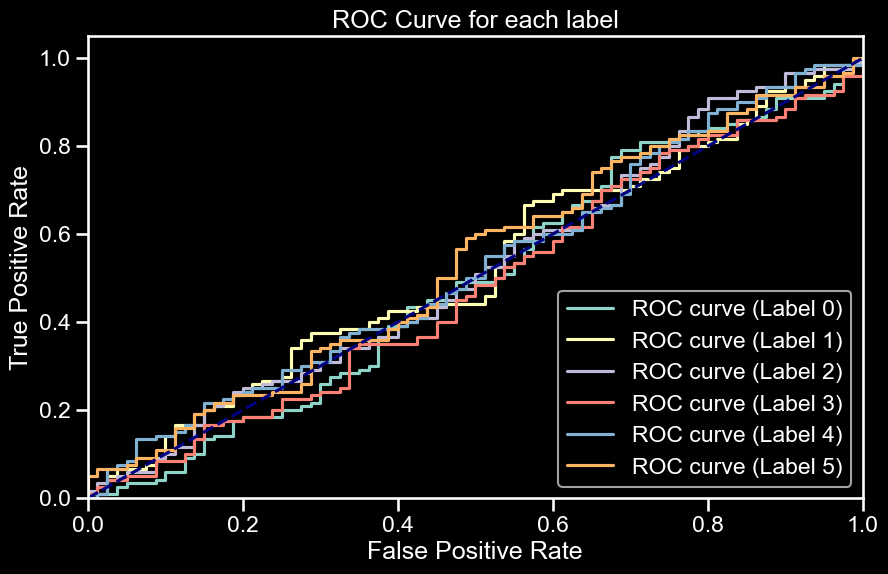

     Label  AUC Score
0  Label 0   0.493542
1  Label 1   0.522292
2  Label 2   0.516771
3  Label 3   0.481250
4  Label 4   0.523438
5  Label 5   0.531563


In [59]:
y_label = torch.where(ground_truth == -1, 1,0)
y_test = torch.rand(200,6)
# print(y_test)
# print(y_label)
get_roc_auc(y_label, y_test)

In [58]:
get_accuracy(y_label, y_test)

0.5016666666666667